# Simulation of anomalous trichromat

This is the ipython notebook that supplements the tutorial [Simulation of anomalous trichromat](https://github.com/atsu-kotani/HumanColorVision/blob/main/Website/tutorials/03_CustomSimulation.md#simulation-of-anomalous-trichromat).

Before running these codes, please make sure you have installed the required packages and set up the environment as described in the [Getting Started](https://github.com/atsu-kotani/HumanColorVision/blob/main/Website/tutorials/00_GettingStarted.md).

Also, make sure you have selected the correct python kernel (e.g. `HumanColorVision`).

---

# Setup

In [1]:
# Load root configuration
import os
import sys
sys.path.append(os.path.join(os.path.dirname(os.path.abspath('__file__')), '..', '..'))
from root_config import ROOT_DIR, DEVICE

# Matplotlib settings for later use in visualization
from matplotlib import font_manager
import matplotlib.pyplot as plt
font_manager.fontManager.addfont(f"{ROOT_DIR}/Tutorials/data/Futura.ttc")
prop = font_manager.FontProperties(fname=f"{ROOT_DIR}/Tutorials/data/Futura.ttc")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 20
plt.rcParams['font.sans-serif'] = prop.get_name()


# Pre-import all the necessary modules
import yaml
import torch
import IPython
import numpy as np
from PIL import Image
import imageio.v2 as imageio
import torch.nn.functional as F
from Experiment.helper import compute_required_image_resolution, largest_valid_region_square

In [2]:
# Pre-define the helper functions for later use

def load_sRGB_image(retina, image_path, params):
    # Loading the input stimulus
    MSS = params['RetinaModel']['max_shift_size']
    current_image_resolution = retina.required_image_resolution + MSS * 2

    image = Image.open(image_path).convert('RGB')
    H, W = image.size
    if H != W:
        if H > W:
            # crop the image
            image = image.crop((0, (H-W)//2, W, (H+W)//2))
        else:
            # crop the image
            image = image.crop(((W-H)//2, 0, (W+H)//2, H))

    image = image.resize((current_image_resolution, current_image_resolution), Image.Resampling.LANCZOS)
    image = np.asarray(image).copy() / 255.0
    image_tensor = torch.FloatTensor(image).to(DEVICE)
    return image_tensor

def get_unwarped_percept(warped_ip_sRGB, cortex):
    xy_full = cortex.P_cell_position.get_XY_default_locations()
    required_image_resolution = compute_required_image_resolution(xy_full.detach().clone())

    grid = cortex.M_global_movement.generate_grid_fixed(xy_full[0,:,0,0], xy_full[0,:,-1,0], xy_full[0,:,0,-1], xy_full[0,:,-1,-1], required_image_resolution)
    uvs = cortex.P_cell_position.get_UV_locations(grid.permute(2,0,1).unsqueeze(0))
    uvs = uvs.repeat(len(warped_ip_sRGB), 1,1,1)

    internal_percept_sRGB = F.grid_sample(warped_ip_sRGB, uvs.permute(0,2,3,1), align_corners=True, mode='bilinear', padding_mode='zeros')

    internal_percept_sRGB = internal_percept_sRGB.squeeze(0).permute(1,2,0).detach().cpu().numpy()
    internal_percept_sRGB = np.clip(internal_percept_sRGB, 0, 1)
    invalid_regions = (((uvs <= -1) | (uvs >= 1)).sum(1) > 0).squeeze(0).cpu().detach().numpy()
    invalid_regions = invalid_regions.astype(int) # (512, 512) image

    best_coords = largest_valid_region_square(invalid_regions)
    cropped_internal_percept_sRGB = internal_percept_sRGB[best_coords[0]:best_coords[2], best_coords[1]:best_coords[3]]

    return cropped_internal_percept_sRGB


In [3]:
# First, instantiate two retina models
# 1. Default trichromat
# 2. Anomalous trichromat

from Simulated.Retina.RetinaModel import RetinaModel

# Load the default parameters for the trichromatic retina simulation
with open(f'{ROOT_DIR}/Experiment/Config/Default/LMS.yaml', 'r') as f:
    default_params = yaml.safe_load(f)
retina_model_default = RetinaModel(default_params)

# Load the parameters for the anomalous trichromatic retina simulation
with open(f'{ROOT_DIR}/Tutorials/03_CustomSimulation/Config/AnomalousTrichromat.yaml', 'r') as f:
    anomalous_trichromat_params = yaml.safe_load(f)
retina_model_anomalous = RetinaModel(anomalous_trichromat_params)

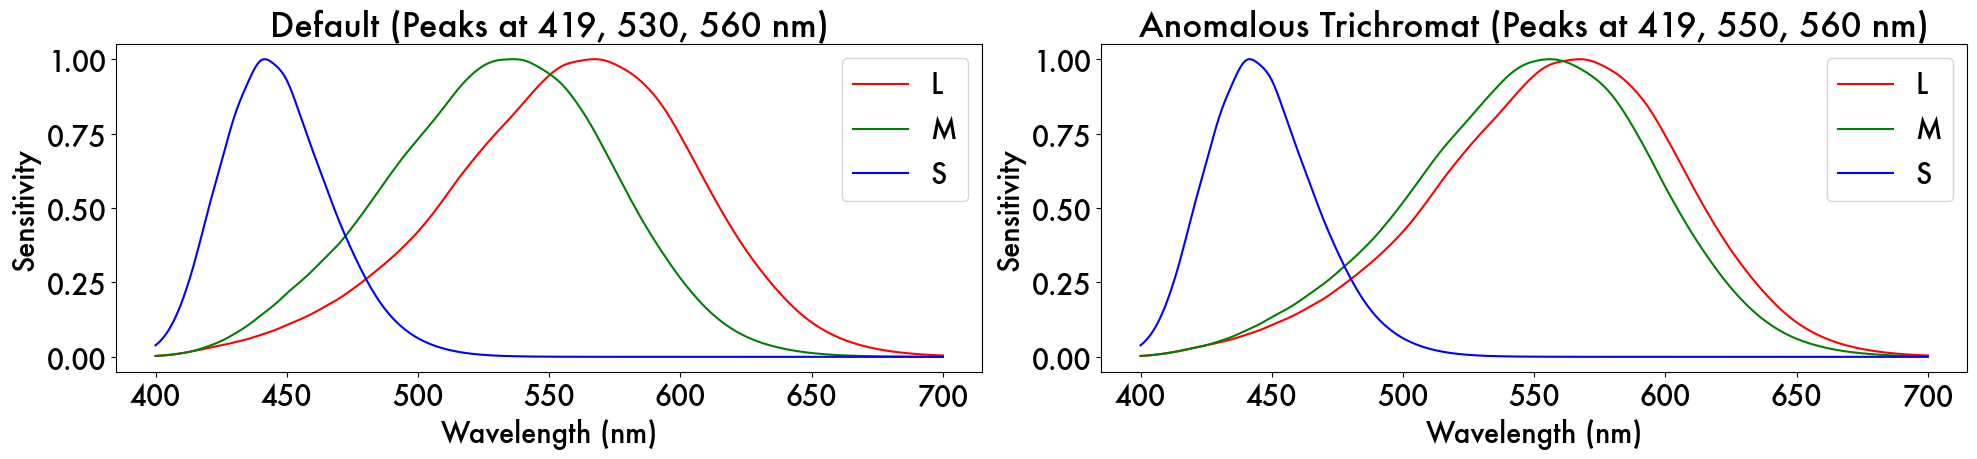

In [10]:
cone_fundamentals_default = retina_model_default.SpectralSampling.get_cone_fundamentals()
cone_fundamentals_anomalous = retina_model_anomalous.SpectralSampling.get_cone_fundamentals()

cone_fundamentals_default = cone_fundamentals_default.cpu().detach().numpy()[:, :3]
cone_fundamentals_anomalous = cone_fundamentals_anomalous.cpu().detach().numpy()[:, :3]

x = [freq for freq in range(400, 701)]
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(x, cone_fundamentals_default[:, 0], label='L', color='red')
axs[0].plot(x, cone_fundamentals_default[:, 1], label='M', color='green')
axs[0].plot(x, cone_fundamentals_default[:, 2], label='S', color='blue')
axs[0].set_title('Default (Peaks at 419, 530, 560 nm)')
axs[0].set_xlabel('Wavelength (nm)')
axs[0].set_ylabel('Sensitivity')
axs[0].legend()
axs[1].plot(x, cone_fundamentals_anomalous[:, 0], label='L', color='red')
axs[1].plot(x, cone_fundamentals_anomalous[:, 1], label='M', color='green')
axs[1].plot(x, cone_fundamentals_anomalous[:, 2], label='S', color='blue')
axs[1].set_title('Anomalous Trichromat (Peaks at 419, 550, 560 nm)')
axs[1].set_xlabel('Wavelength (nm)')
axs[1].set_ylabel('Sensitivity')
axs[1].legend()

plt.tight_layout()
plt.savefig(f'{ROOT_DIR}/Tutorials/data/custom_sim/cone_fundamentals_comparison.png', dpi=300)
plt.show()
plt.close()

In [11]:
# You can change the example_image_path to the path of your own image
example_image_path = f'{ROOT_DIR}/Tutorials/data/sample_sRGB_image.png'


# Default retina simulation
example_sRGB_image = load_sRGB_image(retina_model_default, example_image_path, default_params)
example_linsRGB_image = retina_model_default.CST.sRGB_to_linsRGB(example_sRGB_image)
example_LMS_image = retina_model_default.CST.linsRGB_to_LMS(example_linsRGB_image)
example_LMS_image = example_LMS_image.unsqueeze(0).permute(0, 3, 1, 2)

with torch.no_grad(): # gradient computation is not needed for retina simulation
    list_of_retinal_responses = retina_model_default.forward(example_LMS_image, intermediate_outputs=True)
    optic_nerve_signals_default = list_of_retinal_responses[0]
    photoreceptor_activation_default = list_of_retinal_responses[3]


# Anomalous trichromat retina simulation
example_sRGB_image = load_sRGB_image(retina_model_anomalous, example_image_path, anomalous_trichromat_params)
example_linsRGB_image = retina_model_anomalous.CST.sRGB_to_linsRGB(example_sRGB_image)
example_LMS_image = retina_model_anomalous.CST.linsRGB_to_LMS(example_linsRGB_image)
example_LMS_image = example_LMS_image.unsqueeze(0).permute(0, 3, 1, 2)

with torch.no_grad(): # gradient computation is not needed for retina simulation
    list_of_retinal_responses = retina_model_anomalous.forward(example_LMS_image, intermediate_outputs=True)
    optic_nerve_signals_anomalous = list_of_retinal_responses[0]
    photoreceptor_activation_anomalous = list_of_retinal_responses[3]

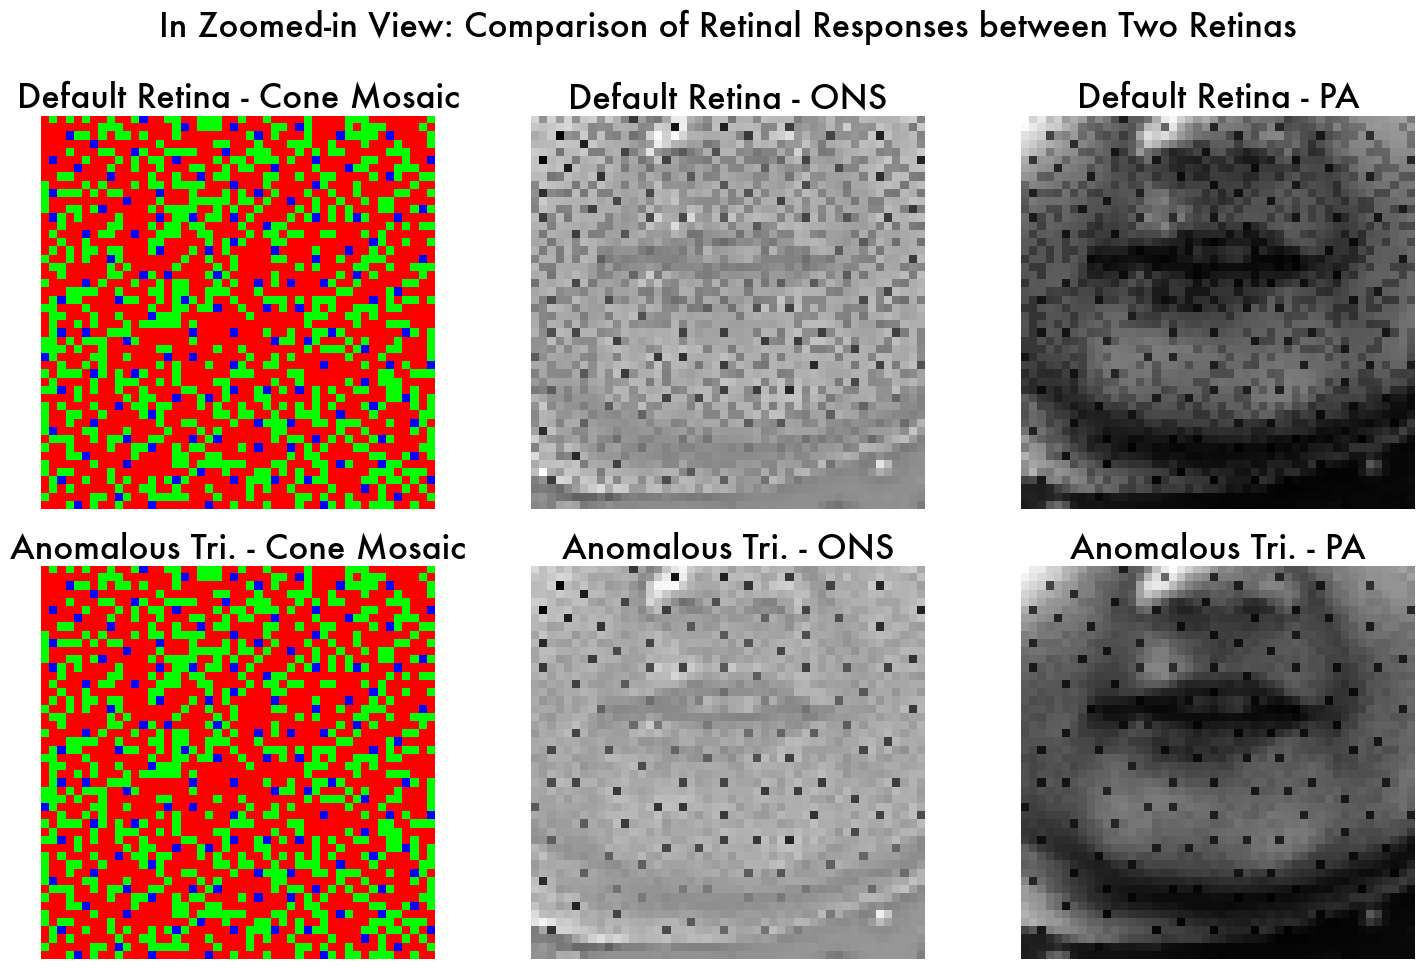

In [18]:
# 2x2 grid of images
optic_nerve_signals_default_numpy = optic_nerve_signals_default[0,0].cpu().detach().numpy()
optic_nerve_signals_anomalous_numpy = optic_nerve_signals_anomalous[0,0].cpu().detach().numpy()
photoreceptor_activation_default_numpy = photoreceptor_activation_default[0,0].cpu().detach().numpy()
photoreceptor_activation_anomalous_numpy = photoreceptor_activation_anomalous[0,0].cpu().detach().numpy()

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

cone_mosaic_default = retina_model_default.SpectralSampling.get_cone_mosaic()[0].permute(1,2,0).cpu().detach().numpy()[:,:,:3]
cone_mosaic_anomalous = retina_model_anomalous.SpectralSampling.get_cone_mosaic()[0].permute(1,2,0).cpu().detach().numpy()[:,:,:3]

axs[0, 0].imshow(cone_mosaic_default[104:152, 104:152])
axs[0, 0].set_title('Default Retina - Cone Mosaic')
axs[0, 0].set_axis_off()
axs[1, 0].imshow(cone_mosaic_anomalous[104:152, 104:152])
axs[1, 0].set_title('Anomalous Tri. - Cone Mosaic')
axs[1, 0].set_axis_off()

axs[0, 1].imshow(optic_nerve_signals_default_numpy[104:152, 104:152], cmap='gray')
axs[0, 1].set_title('Default Retina - ONS')
axs[0, 1].set_axis_off()
axs[1, 1].imshow(optic_nerve_signals_anomalous_numpy[104:152, 104:152], cmap='gray')
axs[1, 1].set_title('Anomalous Tri. - ONS')
axs[1, 1].set_axis_off()

axs[0, 2].imshow(photoreceptor_activation_default_numpy[104:152, 104:152], cmap='gray')
axs[0, 2].set_title('Default Retina - PA')
axs[0, 2].set_axis_off()
axs[1, 2].imshow(photoreceptor_activation_anomalous_numpy[104:152, 104:152], cmap='gray')
axs[1, 2].set_title('Anomalous Tri. - PA')
axs[1, 2].set_axis_off()

fig.suptitle('In Zoomed-in View: Comparison of Retinal Responses between Two Retinas')

plt.tight_layout()
os.makedirs(f'{ROOT_DIR}/Tutorials/data/custom_sim', exist_ok=True)
plt.savefig(f'{ROOT_DIR}/Tutorials/data/custom_sim/anomalous_trichromat_comparison.png', dpi=300)
plt.show()
plt.close()

In [7]:
# Load the default cortex model
from Simulated.Cortex.CortexModel import CortexModel
cortex_model_default = CortexModel(default_params).to(DEVICE)
cortex_model_default = torch.compile(cortex_model_default)

# load the pre-trained weights
cortex_model_default.load_state_dict(torch.load(f'{ROOT_DIR}/Experiment/LearnedWeights/LMS/100000.pt', weights_only=True, map_location=DEVICE))

# get the internal percepts
with torch.no_grad():
    default_warped_internal_percept = cortex_model_default.decode(optic_nerve_signals_default[:,:1])
    default_warped_internal_percept_linsRGB = cortex_model_default.ns_ip.forward(default_warped_internal_percept)

    # Then we use the retina.CST (color space transform) to convert the linsRGB space to the sRGB space
    default_warped_internal_percept_sRGB = retina_model_default.CST.linsRGB_to_sRGB(default_warped_internal_percept_linsRGB)

    # get_unwarped_percept is a helper function defined in the ipython notebook file
    default_internal_percept_sRGB = get_unwarped_percept(default_warped_internal_percept_sRGB, cortex_model_default)


# get the internal percepts for the ons simulated by the anomalous trichromat retina
with torch.no_grad():
    anomalous_warped_internal_percept = cortex_model_default.decode(optic_nerve_signals_anomalous[:,:1])
    anomalous_warped_internal_percept_linsRGB = cortex_model_default.ns_ip.forward(anomalous_warped_internal_percept)
    anomalous_warped_internal_percept_sRGB = retina_model_default.CST.linsRGB_to_sRGB(anomalous_warped_internal_percept_linsRGB)
    anomalous_internal_percept_sRGB = get_unwarped_percept(anomalous_warped_internal_percept_sRGB, cortex_model_default)

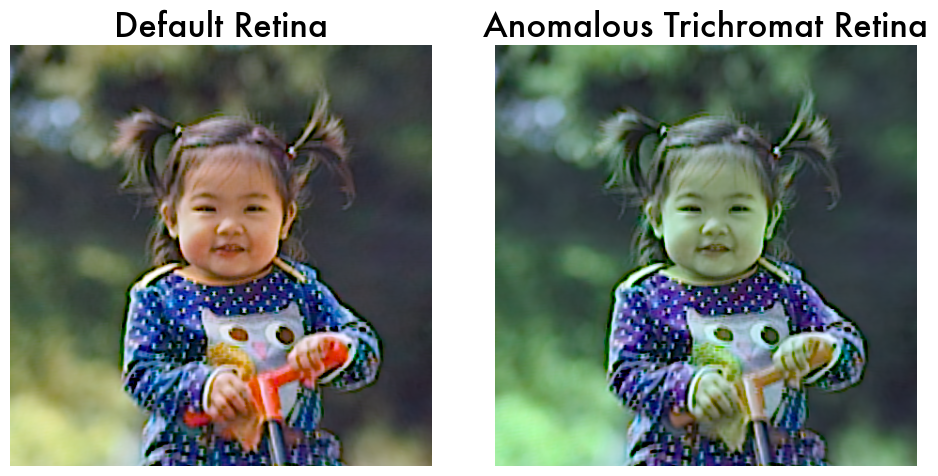

In [8]:
# side by side comparison
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(default_internal_percept_sRGB)
axs[0].set_title('Default Retina')
axs[0].set_axis_off()
axs[1].imshow(anomalous_internal_percept_sRGB)
axs[1].set_title('Anomalous Trichromat Retina')
axs[1].set_axis_off()
plt.tight_layout()
os.makedirs(f'{ROOT_DIR}/Tutorials/data/custom_sim', exist_ok=True)
plt.savefig(f'{ROOT_DIR}/Tutorials/data/custom_sim/simulating_anomalous_view_from_default_model.png', dpi=300)
plt.show()
plt.close()